In [ ]:
import ssl; ssl._create_default_https_context = ssl._create_unverified_context
!pip install -q albumentations==1.4.7 opencv-python-headless==4.10.0.84

import os, json, numpy as np
from PIL import Image

import torch
import torch.utils.data
from torch.utils.data import Subset, DataLoader
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn

from pycocotools.coco import COCO

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
input_path  = "/content/drive/MyDrive/Archive/result.json"
output_path = "/content/drive/MyDrive/Archive/result_modified.json"

with open(input_path, "r") as f:
    data = json.load(f)

for ann in data.get("annotations", []):
    ann["category_id"] = int(ann["category_id"]) + 1

for cat in data.get("categories", []):
    cat["id"] = int(cat["id"]) + 1

with open(output_path, "w") as f:
    json.dump(data, f, indent=4)

print(f"✅ Modified JSON saved at: {output_path}")

✅ Modified JSON saved at: /content/drive/MyDrive/Archive/result_modified.json


In [ ]:
def get_transform(train: bool, strength: str = "mild"):
    if not train:
        return None

    if strength == "mild":
        aug = [
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.15,
                               rotate_limit=10, border_mode=0, p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2,
                          saturation=0.2, hue=0.02, p=0.5),
        ]
    else:  # strong
        aug = [
            A.HorizontalFlip(p=0.5),
            A.RandomResizedCrop(height=896, width=896, scale=(0.5, 1.0), p=0.7),
            A.ShiftScaleRotate(shift_limit=0.08, scale_limit=0.25,
                               rotate_limit=15, border_mode=0, p=0.7),
            A.RandomBrightnessContrast(p=0.5),
            A.HueSaturationValue(p=0.3),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        ]

    return A.Compose(
        aug + [A.ToFloat(max_value=255.0), ToTensorV2()],
        bbox_params=A.BboxParams(
            format="pascal_voc", label_fields=["labels"], min_visibility=0.3
        )
    )


In [ ]:
class CustomCocoDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annotation_file, transforms=None):
        """
        images_dir: directory with images
        annotation_file: COCO JSON path (after category shift)
        transforms: Albumentations Compose or None
        """
        self.images_dir = images_dir
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transforms = transforms

    def __getitem__(self, index):
        coco_img_id = self.ids[index]
        img_info = self.coco.loadImgs(coco_img_id)[0]
        path = os.path.join(self.images_dir, img_info['file_name'])

        # Albumentations expects np.ndarray (H,W,C)
        image = np.array(Image.open(path).convert("RGB"))
        H, W = image.shape[:2]

        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=coco_img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes, masks, labels, areas, iscrowd = [], [], [], [], []
        for ann in anns:
            if 'bbox' not in ann:
                continue
            x, y, w, h = ann['bbox']  # COCO xywh
            x1, y1 = x, y
            x2, y2 = x + w, y + h
            # Clamp to image bounds to avoid tiny numeric spillovers
            x1 = max(0, min(x1, W - 1))
            y1 = max(0, min(y1, H - 1))
            x2 = max(0, min(x2, W - 1))
            y2 = max(0, min(y2, H - 1))
            if x2 <= x1 or y2 <= y1:
                continue

            boxes.append([x1, y1, x2, y2])           # pascal_voc (pixels)
            masks.append(self.coco.annToMask(ann))   # (H, W) uint8
            labels.append(int(ann['category_id']))
            areas.append(float(ann['area']))
            iscrowd.append(int(ann.get('iscrowd', 0)))

        # Default empty arrays/lists
        if len(boxes) == 0:
            boxes_list   = []
            masks_list   = []
            labels_list  = []
        else:
            boxes_list   = boxes
            masks_list   = [m.astype(np.uint8) for m in masks]
            labels_list  = labels

        if self.transforms is not None:
            # Albumentations call with NAMED ARGS
            try:
                transformed = self.transforms(
                    image=image,
                    masks=masks_list,         # list of HxW arrays
                    bboxes=boxes_list,        # list of [x1,y1,x2,y2] in PIXELS
                    labels=labels_list
                )
            except Exception as e:
                print("Aug error on:", path)
                raise

            image_t   = transformed["image"]          # torch.FloatTensor CxHxW (float [0,1])
            new_boxes = transformed.get("bboxes", []) # still PIXELS
            new_masks = transformed.get("masks", [])
            new_labels= transformed.get("labels", [])

            Hn, Wn = image_t.shape[1], image_t.shape[2]

            if len(new_boxes) == 0:
                boxes_t   = torch.zeros((0, 4), dtype=torch.float32)
                labels_t  = torch.zeros((0,), dtype=torch.int64)
                masks_t   = torch.zeros((0, Hn, Wn), dtype=torch.uint8)
                areas_t   = torch.zeros((0,), dtype=torch.float32)
                iscrowd_t = torch.zeros((0,), dtype=torch.int64)
            else:
                boxes_t  = torch.tensor(new_boxes, dtype=torch.float32)
                labels_t = torch.tensor(new_labels, dtype=torch.int64)

                if len(new_masks):
                    masks_np = np.stack(new_masks, axis=0) if isinstance(new_masks, list) else new_masks
                    masks_t = torch.tensor(masks_np, dtype=torch.uint8)
                    # Align count if anything was dropped
                    if masks_t.shape[0] != boxes_t.shape[0]:
                        minN = min(masks_t.shape[0], boxes_t.shape[0])
                        masks_t  = masks_t[:minN]
                        boxes_t  = boxes_t[:minN]
                        labels_t = labels_t[:minN]
                else:
                    masks_t = torch.zeros((0, Hn, Wn), dtype=torch.uint8)

                if boxes_t.numel():
                    w = (boxes_t[:, 2] - boxes_t[:, 0]).clamp(min=0)
                    h = (boxes_t[:, 3] - boxes_t[:, 1]).clamp(min=0)
                    areas_t = (w * h).to(torch.float32)
                else:
                    areas_t = torch.zeros((0,), dtype=torch.float32)

                iscrowd_t = torch.zeros((boxes_t.shape[0],), dtype=torch.int64)

            target = {
                "boxes":    boxes_t,
                "labels":   labels_t,
                "masks":    masks_t,
                "image_id": torch.tensor([coco_img_id], dtype=torch.int64),
                "area":     areas_t,
                "iscrowd":  iscrowd_t,
            }
            image = image_t
        else:
            # Validation: plain tensor conversion
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
            if len(boxes_list):
                boxes_t  = torch.tensor(boxes_list, dtype=torch.float32)
                labels_t = torch.tensor(labels_list, dtype=torch.int64)
                masks_t  = torch.tensor(np.stack(masks_list, axis=0), dtype=torch.uint8)
                w = (boxes_t[:, 2] - boxes_t[:, 0]).clamp(min=0)
                h = (boxes_t[:, 3] - boxes_t[:, 1]).clamp(min=0)
                areas_t = (w * h).to(torch.float32)
                iscrowd_t = torch.zeros((boxes_t.shape[0],), dtype=torch.int64)
            else:
                H0, W0 = image.shape[1], image.shape[2]
                boxes_t   = torch.zeros((0, 4), dtype=torch.float32)
                labels_t  = torch.zeros((0,), dtype=torch.int64)
                masks_t   = torch.zeros((0, H0, W0), dtype=torch.uint8)
                areas_t   = torch.zeros((0,), dtype=torch.float32)
                iscrowd_t = torch.zeros((0,), dtype=torch.int64)

            target = {
                "boxes":    boxes_t,
                "labels":   labels_t,
                "masks":    masks_t,
                "image_id": torch.tensor([coco_img_id], dtype=torch.int64),
                "area":     areas_t,
                "iscrowd":  iscrowd_t,
            }

        return image, target

    def __len__(self):
        return len(self.ids)

def collate_fn(batch):
    return tuple(zip(*batch))

dataset_dir = "/content/drive/MyDrive/Archive/"
images_dir = os.path.join(dataset_dir, "images")
annotation_file = os.path.join(dataset_dir, "result_modified.json")

train_tfms = get_transform(train=True, strength="mild")  # or "strong"
val_tfms   = get_transform(train=False)

full_train_dataset = CustomCocoDataset(images_dir, annotation_file, transforms=train_tfms)
full_val_dataset   = CustomCocoDataset(images_dir, annotation_file, transforms=val_tfms)

indices = list(range(len(full_train_dataset)))
train_indices = indices[:60]
val_indices   = indices[60:]

train_dataset = Subset(full_train_dataset, train_indices)
val_dataset   = Subset(full_val_dataset, val_indices)

# Use num_workers=0 while debugging to see clear errors
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/usr/local/lib/python3.12/dist-packages/pydantic/main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `float` - serialized value may not be as expected [input_value=[0.8, 1.2], input_type=list])
  PydanticSerializationUnexpectedValue(Expected `tuple[float, float]` - serialized value may not be as expected [input_value=[0.8, 1.2], input_type=list])
  PydanticSerializationUnexpectedValue(Expected `float` - serialized value may not be as expected [input_value=[0.8, 1.2], input_type=list])
  PydanticSerializationUnexpectedValue(Expected `tuple[float, float]` - serialized value may not be as expected [input_value=[0.8, 1.2], input_type=list])
  PydanticSerializationUnexpectedValue(Expected `float` - serialized value may not be as expected [input_value=[0.8, 1.2], input_type=list])
  PydanticSerializationUnexpectedValue(Expected `tuple[float, float]` - serialized value may not be as expected [input_value=[0.8, 1.2], input_type=list])
  Pydan

In [ ]:
num_classes = 2  # 1 class + background

# For newer torchvision you can use: maskrcnn_resnet50_fpn(weights="DEFAULT")
# model = maskrcnn_resnet50_fpn(pretrained=True)
model = maskrcnn_resnet50_fpn(pretrained=True,
    box_score_thresh=0.05,   # default 0.05 is fine; if you raised it, bring it back down
    box_nms_thresh=0.5,      # try 0.5–0.6
    rpn_nms_thresh=0.7,      # try 0.7–0.8 to get more proposals
    min_size=640, max_size=1024
)
# RPN: generate more candidates, keep NMS a bit looser
model.rpn.pre_nms_top_n_train = 2000
model.rpn.post_nms_top_n_train = 1000
model.rpn.pre_nms_top_n_test  = 2000
model.rpn.post_nms_top_n_test = 1000
model.rpn.nms_thresh = 0.8              # was 0.7 by default

# ROI heads: accept more proposals into the classifier
model.roi_heads.batch_size_per_image = 256  # default 128
model.roi_heads.positive_fraction = 0.5     # default 0.25; try 0.5 for more positives

# Scoring/NMS at the ROI stage
model.roi_heads.score_thresh = 0.05         # keep low for eval (COCO eval filters itself)
model.roi_heads.nms_thresh   = 0.5          # slightly tighter to remove dupes


# Replace heads
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
    in_features_mask, hidden_layer, num_classes
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640,), max_size=1024, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4, weight_decay=1e-4)

from torch.amp import autocast, GradScaler
scaler = GradScaler(device="cuda")

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)



patience_es, best_val_loss, bad_epochs = 6, float("inf"), 0

# patience_es=6
num_epochs = 40
train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
        # before training
    for p in model.backbone.parameters():
        p.requires_grad = False

    # after 2 epochs
    if epoch == 2:
        for p in model.backbone.parameters():
            p.requires_grad = True

    for images, targets in train_loader:
        images  = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad(set_to_none=True)

        with autocast(device_type="cuda"):
            loss_dict = model(images, targets)
            loss = sum(loss_dict.values())

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        scaler.step(optimizer)
        scaler.update()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / max(1, len(train_loader))

    train_losses.append(avg_train_loss)

    # ---- "Val" loss (set train mode but no grad so model returns loss dict) ----
        # Validation
    model.train()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for images, targets in val_loader:
            images  = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            loss = sum(loss_dict.values())
            epoch_val_loss += loss.item()

    avg_val_loss = epoch_val_loss / max(1, len(val_loader))
    avg_val_loss = epoch_val_loss / max(1, len(val_loader))
    scheduler.step(avg_val_loss)

    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

    # Save + early stop
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        bad_epochs = 0
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Saved best model at epoch {epoch+1}")
    else:
        bad_epochs += 1
        if bad_epochs >= patience_es:
            print("⏹️ Early stopping triggered")
            break


Epoch 1/40 | Train: 1.2097 | Val: 0.9570
✅ Saved best model at epoch 1
Epoch 2/40 | Train: 0.7786 | Val: 0.8612
✅ Saved best model at epoch 2
Epoch 3/40 | Train: 0.7723 | Val: 0.8845
Epoch 4/40 | Train: 0.6679 | Val: 0.8120
✅ Saved best model at epoch 4
Epoch 5/40 | Train: 0.6090 | Val: 0.8421
Epoch 6/40 | Train: 0.5914 | Val: 0.7708
✅ Saved best model at epoch 6
Epoch 7/40 | Train: 0.5932 | Val: 0.7555
✅ Saved best model at epoch 7
Epoch 8/40 | Train: 0.5505 | Val: 0.7990
Epoch 9/40 | Train: 0.5728 | Val: 0.7784
Epoch 10/40 | Train: 0.5245 | Val: 0.7850
Epoch 11/40 | Train: 0.4958 | Val: 0.7899
Epoch 12/40 | Train: 0.4899 | Val: 0.7737
Epoch 13/40 | Train: 0.5211 | Val: 0.7787
⏹️ Early stopping triggered



🔍 Visualizing Top-1 Image with Avg Score: 0.41


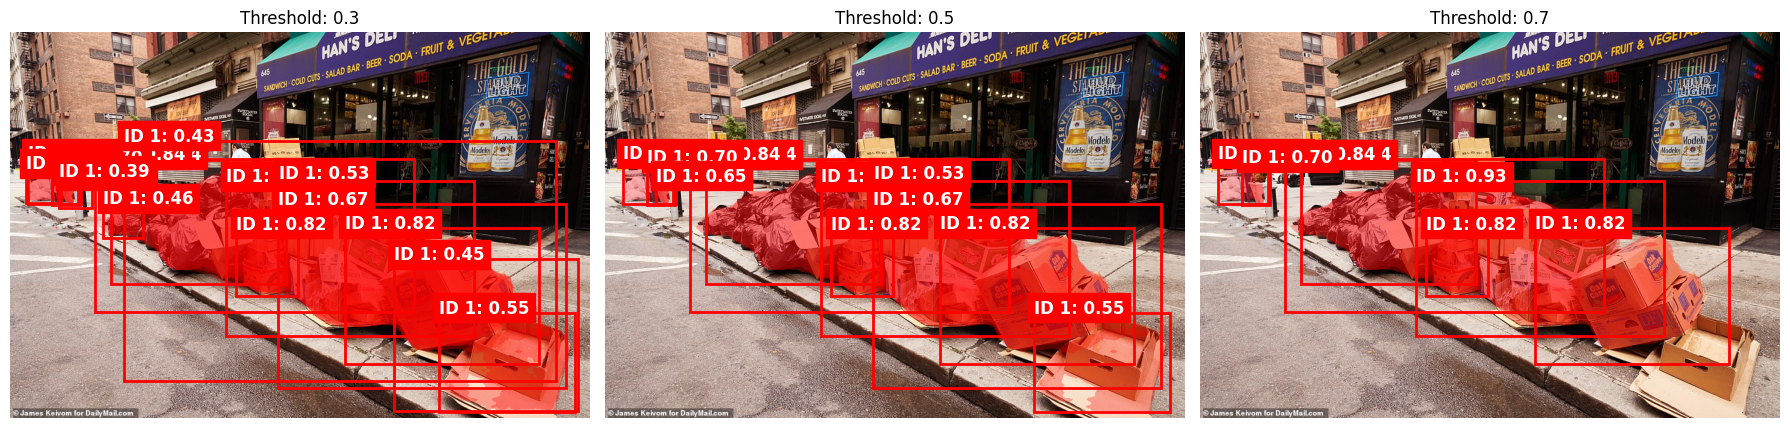


🔍 Visualizing Top-2 Image with Avg Score: 0.39


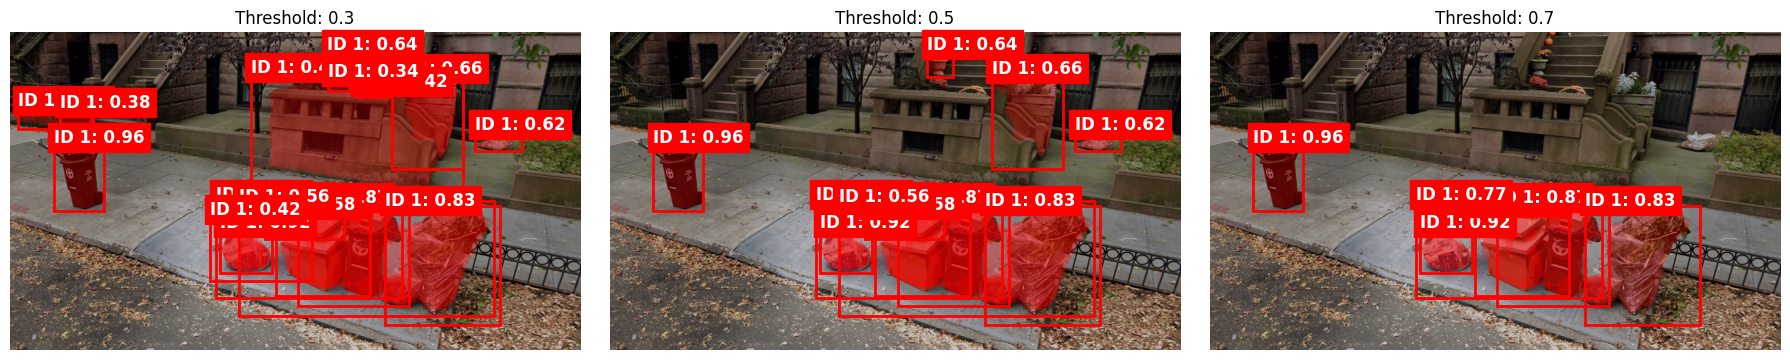


🔍 Visualizing Top-3 Image with Avg Score: 0.39


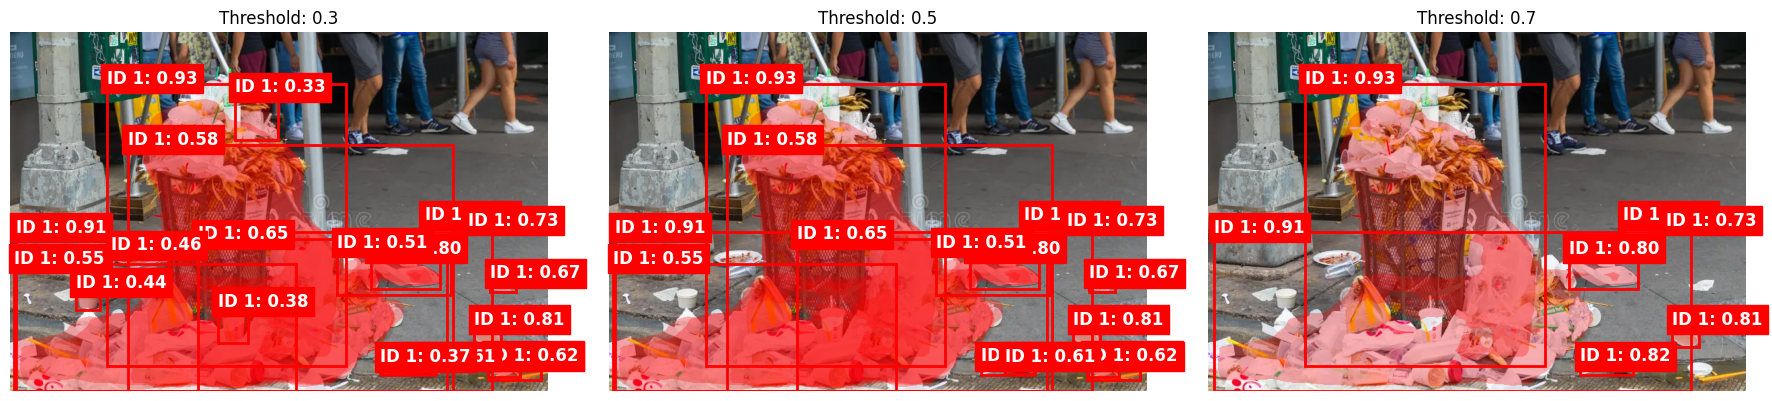

In [ ]:
import matplotlib.pyplot as plt
import numpy as np  # already imported, but keep here for safety

def visualize_prediction_multi_thresholds(image, prediction, thresholds=[0.3, 0.5, 0.7]):
    """
    Visualizes the same image with predictions at different confidence thresholds.

    image: Tensor of shape [3, H, W]
    prediction: Dict with 'boxes', 'scores', 'masks', 'labels'
    thresholds: List of threshold values to compare
    """
    image_np = image.mul(255).byte().cpu().permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, len(thresholds), figsize=(6 * len(thresholds), 8))
    if len(thresholds) == 1:
        axs = [axs]  # make iterable if single threshold

    boxes = prediction['boxes'].detach().cpu().numpy()
    scores = prediction['scores'].detach().cpu().numpy()
    masks = prediction['masks'].detach().cpu().numpy()
    labels = prediction['labels'].detach().cpu().numpy()

    for ax, thresh in zip(axs, thresholds):
        ax.imshow(image_np)
        ax.set_title(f"Threshold: {thresh}")
        for i, score in enumerate(scores):
            if score > thresh:
                x1, y1, x2, y2 = boxes[i]
                rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     fill=False, color='red', linewidth=2)
                ax.add_patch(rect)
                ax.text(x1, y1, f'ID {labels[i]}: {score:.2f}',
                        color='white', fontsize=12, weight='bold',
                        backgroundcolor='red')
                mask = masks[i, 0] > 0.5
                colored_mask = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.float32)
                colored_mask[..., 0] = 1.0  # Red
                colored_mask[..., 3] = 0.3 * mask.astype(np.float32)
                ax.imshow(colored_mask)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

top_images = []

# Now switch model to evaluation mode for inference
model.eval()

with torch.no_grad():
    for images, targets in val_loader:
        for img in images:
            img = img.to(device)
            prediction = model([img])[0]
            avg_score = prediction['scores'].mean().item() if len(prediction['scores']) > 0 else 0
            top_images.append((avg_score, img.cpu(), prediction))

# Sort by average score descending
top_images.sort(key=lambda x: x[0], reverse=True)

# Pick top 3
top_3 = top_images[:3]

# Visualize each with multiple thresholds
for i, (avg_score, image, prediction) in enumerate(top_3):
    print(f"\n🔍 Visualizing Top-{i+1} Image with Avg Score: {avg_score:.2f}")
    visualize_prediction_multi_thresholds(image, prediction, thresholds=[0.3, 0.5, 0.7])


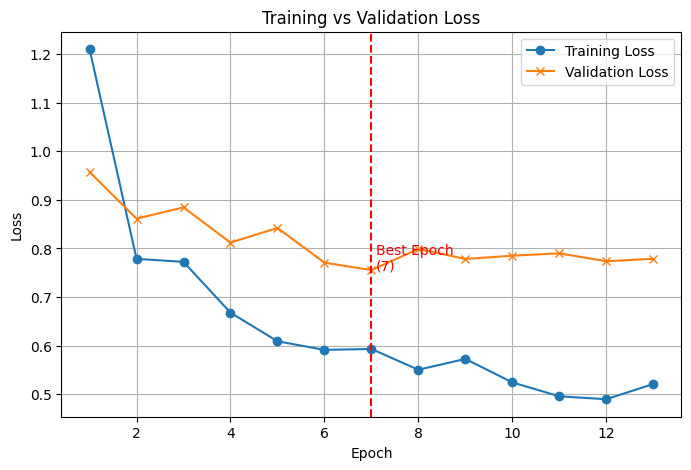

In [ ]:
import matplotlib.pyplot as plt
if val_losses and train_losses:
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)

    # Best epoch marker
    best_epoch = val_losses.index(min(val_losses)) + 1
    plt.axvline(best_epoch, linestyle='--', color='red', label=f'Best Epoch: {best_epoch}')
    plt.text(best_epoch + 0.1, min(val_losses), f'Best Epoch\n({best_epoch})', color='red')

    plt.show()
else:
    print("⚠️ No losses recorded. Did the training loop run?")



In [ ]:
# ===== COCO Evaluation: bbox + segm (per-class + overall) =====
import torch, numpy as np, json, collections
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

@torch.no_grad()
def evaluate_coco(model, data_loader, annotation_file, device, score_thresh=0.0):
    """
    Runs inference on data_loader and computes COCO metrics for bbox and segm.
    Returns a dict with overall metrics and per-class AP tables.
    """
    model.eval()

    # ---- Collect predictions as COCO-format results ----
    bbox_results, segm_results = [], []
    for images, targets in data_loader:
        # images: list[Tensor CxHxW]
        images = [img.to(device) for img in images]
        outputs = model(images)  # list of dicts

        for out, tgt in zip(outputs, targets):
            image_id = int(tgt["image_id"].item())
            boxes  = out["boxes"].detach().cpu().numpy() if "boxes" in out else np.zeros((0,4))
            scores = out["scores"].detach().cpu().numpy() if "scores" in out else np.zeros((0,))
            labels = out["labels"].detach().cpu().numpy() if "labels" in out else np.zeros((0,), dtype=np.int64)
            masks  = out.get("masks", None)
            if masks is not None:
                masks = masks.detach().cpu().numpy()  # [N,1,H,W]

            keep = scores > score_thresh
            boxes, scores, labels = boxes[keep], scores[keep], labels[keep]
            if masks is not None:
                masks = masks[keep]

            # bbox: convert [x1,y1,x2,y2] -> [x,y,w,h]
            for box, score, label in zip(boxes, scores, labels):
                x1,y1,x2,y2 = box.tolist()
                w = max(0.0, x2 - x1); h = max(0.0, y2 - y1)
                bbox_results.append({
                    "image_id": image_id,
                    "category_id": int(label),
                    "bbox": [float(x1), float(y1), float(w), float(h)],
                    "score": float(score),
                })

            # segm: encode masks to RLE
            if masks is not None:
                for m, score, label in zip(masks, scores, labels):
                    # m: [1,H,W], threshold at 0.5
                    m_bin = (m[0] > 0.5).astype(np.uint8)
                    if m_bin.sum() == 0:
                        # empty mask — skip to avoid COCOeval issues
                        continue
                    rle = maskUtils.encode(np.asfortranarray(m_bin))
                    rle["counts"] = rle["counts"].decode("utf-8")  # bytes -> str
                    segm_results.append({
                        "image_id": image_id,
                        "category_id": int(label),
                        "segmentation": rle,
                        "score": float(score),
                    })

    # ---- Load GT and run COCOeval ----
    coco_gt = COCO(annotation_file)

    results = {}
    for key, preds, iou_type in [
        ("bbox", bbox_results, "bbox"),
        ("segm", segm_results, "segm"),
    ]:
        if len(preds) == 0:
            print(f"⚠️ No predictions for {key}. Skipping.")
            results[key] = None
            continue

        coco_dt = coco_gt.loadRes(preds)
        from pycocotools.cocoeval import COCOeval
        coco_eval = COCOeval(coco_gt, coco_dt, iouType=iou_type)
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        # Overall summary (matches COCOeval.summarize() order)
        # stats: [AP, AP50, AP75, AP_small, AP_medium, AP_large, AR@1, AR@10, AR@100, AR_small, AR_medium, AR_large]
        summary = {
            "AP@[.5:.95]": float(coco_eval.stats[0]),
            "AP@0.5":      float(coco_eval.stats[1]),
            "AP@0.75":     float(coco_eval.stats[2]),
            "AP_small":    float(coco_eval.stats[3]),
            "AP_medium":   float(coco_eval.stats[4]),
            "AP_large":    float(coco_eval.stats[5]),
            "AR@1":        float(coco_eval.stats[6]),
            "AR@10":       float(coco_eval.stats[7]),
            "AR@100":      float(coco_eval.stats[8]),
            "AR_small":    float(coco_eval.stats[9]),
            "AR_medium":   float(coco_eval.stats[10]),
            "AR_large":    float(coco_eval.stats[11]),
        }

        # ---- Per-class AP (0.5:0.95) ----
        # precision: [TxRxKxAxM]  (IoU thresholds x recall thresholds x categories x area ranges x maxDet)
        precisions = coco_eval.eval["precision"]  # shape [10, 101, K, 4, 3] typically
        catIds = coco_gt.getCatIds()
        per_class_ap = collections.OrderedDict()
        for idx, catId in enumerate(catIds):
            # slice over IoU & recall, area=all (a=0), maxDets=100 (m=2)
            p = precisions[:, :, idx, 0, 2]
            p = p[p > -1]  # remove invalid entries (-1)
            ap = float(np.mean(p)) if p.size else float("nan")
            name = coco_gt.loadCats([catId])[0]["name"]
            per_class_ap[name] = ap

        results[key] = {"summary": summary, "per_class_ap": per_class_ap}

    return results

# ===== Run evaluation on your validation loader =====
metrics = evaluate_coco(model, val_loader, annotation_file, device)

# Pretty print results
def print_metrics(metrics):
    for k in ["bbox", "segm"]:
        if metrics.get(k) is None:
            continue
        print("\n==============================")
        print(f"COCO {k.upper()} METRICS (overall)")
        for kk, vv in metrics[k]["summary"].items():
            print(f"{kk:>10}: {vv:0.4f}")

        print(f"\nCOCO {k.upper()} PER-CLASS AP:")
        for cls, ap in metrics[k]["per_class_ap"].items():
            print(f"{cls:>20}: {ap:0.4f}")

print_metrics(metrics)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.28s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.031
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.056
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.018
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.066
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets